In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq2 as s2s2
import seq2seq as s2s
from numpy.linalg import inv
import transform_space as ts
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import pairwise_distances,homogeneity_completeness_v_measure,silhouette_score,calinski_harabaz_score


In [2]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [3]:
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
nb_trajectories_per_object = 1
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories = [t for o in trajectories_po for t in o]
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]

In [4]:
nb_trajectories

2376

In [5]:
# start at 1
import math
def get_neighboorhood(nb_label,nb_col,hot_cells):
    centroids = []
    neighboorhoods = []
    s = 5
    for n in range(1,nb_label+1):
        r = int(math.ceil(n/float(nb_col)))
        c = nb_col - (r*nb_col - n)
        centroid = [(r-1+0.5)*s,(c-1+0.5)*s ]
        centroids.append(centroid)
        neighboors = [ j*nb_col + i for i in range(c-1,c+2) for j in range(r-1,r+2)  if j*nb_col + i < nb_label+1   and j*nb_col + i != r*nb_col + c and j*nb_col + i != 0 ]
        neighboorhoods.append(neighboors)
    return neighboorhoods,centroids

def get_hot_cells(discretized_trajectory,nb_label,threshold = 15):
    a = [i for t in discretized_trajectory for i in t]
    b = [0 for i in range(nb_label)]

    for e in a:
        b[e-1] += 1


    hot_cells = [False for i in range(nb_label)]
    for i,e in enumerate(b):
        if e > threshold:
            hot_cells[i] = True 
    
    return hot_cells




def replace_cold_cells(discretized_trajectory,hot_cells,neighboorhoods):
    for trajectory in discretized_trajectory:
        for i,p in enumerate(trajectory):
            #print(p)
            if not hot_cells[p-1]:
                #if neighboorhoods[p] != []:
                hot_neighbors = [n for n in neighboorhoods[p] if hot_cells[n-1]]
                if hot_neighbors != []:
                    trajectory[i] = np.random.choice(hot_neighbors)
                else:
                    trajectory.remove(trajectory[i])
                    i -= 1
    return discretized_trajectory


def discretize_trajectories(trajectories,w,h,s = 5):
    w,h = int(round(w)),int(round(h))
    
    nb_label,nb_row,nb_col = ts.get_nb_label(h,w,s)
    discretized_trajectory = [ts.discretize1(t,s,nb_col) for t in trajectories]
    
    hot_cells = get_hot_cells(discretized_trajectory,nb_label)
    #print(hot_cells)
    #print(len(hot_cells))
    neighboorhoods,centroids = get_neighboorhood(nb_label,nb_col,hot_cells)
    discretized_trajectory = replace_cold_cells(discretized_trajectory,hot_cells,neighboorhoods)
    # input_size = nb_label +3
    nb_label = np.sum([1 for h in hot_cells if h])
    
    labels = [ i+1 for i,h in enumerate(hot_cells) if h]
    
    
    #print(labels)
    #print([np.max(labels)+1,np.max(labels)+2])
    
    labels = labels + [np.max(labels)+1,np.max(labels)+2]
    
    dico = {}
    for i,l in enumerate(labels):
        dico[str(l)] = str(i)
    
    for i,t in enumerate(discretized_trajectory):
        for j,p in enumerate(t):
            t[j] = int(dico[str(p)])
            
    #print(labels)
    input_size = nb_label +2
    return discretized_trajectory,nb_label,nb_row,nb_col,input_size,labels,dico,centroids,hot_cells

from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_states_eos1(nb_label,discretized_trajectory):
    ohe = OneHotEncoder(sparse = False, dtype=np.int)
    #words = np.arange(nb_label+2)
    ohe = ohe.fit(np.arange(nb_label+2).reshape(-1,1))

    eos = [nb_label+1]
    #print(eos)
    input_data = [t+eos for t in discretized_trajectory]
    #print(input_data)
    input_data_encoded = np.array([np.array([ohe.transform(p)[0] for p in t]) for t in input_data])
    
    sos = np.array([nb_label])
    sos_encoded = [ohe.transform(sos[0].reshape(1,-1))[0]]
    
    return input_data,input_data_encoded,sos,sos_encoded


In [15]:
trajectories_ts,w,h = ts.transform_original_space(trajectories)

discretized_trajectory,nb_label,nb_row,nb_col,input_size,labels,dico,centroids,hot_cells  = discretize_trajectories(trajectories_ts,w,h,s = 5)
#reversed_discretized_trajectory = [[t[-i] for i in range(1,len(t)+1)] for t in discretized_trajectory ]


output_data,_, sos,sos_encoded = one_hot_encode_states_eos1(nb_label,discretized_trajectory)
#input_data,input_data_encoded, _,_ = one_hot_encode_states_eos1(nb_label,reversed_discretized_trajectory)
input_data,input_data_encoded, _,_ = one_hot_encode_states_eos1(nb_label,discretized_trajectory)


#input_data = [[t[-i] for i in range(1,len(t)+1)] for t in output_data_encoded ]
# append 

#features = s2s.unify_trajectory_sizes(encoder,input_data,input_size = input_size)

In [16]:
np.mean([len(t) for t in discretized_trajectory])

8.214646464646465

In [17]:
centroids = [c for i,c in enumerate(centroids) if hot_cells[i]]

In [18]:
from scipy.spatial.distance import euclidean
from math import exp
def loss_weight(predicted,real,centroids,theta):
    du = euclidean(centroids[predicted],centroids[real])
    sdv = np.sum([exp(-euclidean(centroids[real],c)/theta) for c in centroids])
    w = exp(-du/theta)/sdv
    return w

#loss_weight(p,r,centroids,20)
# gerer centroid pour sos et eos
# a l4infini

In [19]:
centroids.append([300,300])
centroids.append([300,310])

In [20]:

weight_matrix = [[ [] for j in range(input_size)] for i in range(input_size)]
for i in range(input_size):
    for j in range(i,input_size):
        weight_matrix[i][j] = loss_weight(j,i,centroids,10)
        weight_matrix[j][i] = weight_matrix[i][j]

In [31]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random
import time
import copy
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import pandas as pd
import utils as ut
import features as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size,num_layers=1)

    def forward(self, input_, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        #output = embedded
        output = input_

        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size,num_layers=1)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_, hidden):
        #output = self.embedding(input).view(1, 1, -1)
        #output = F.relu(output)
        output = input_
        
        output, hidden = self.gru(output, hidden)
        
        output = self.out(output)
        
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self, h):
        return torch.zeros(1, 1, self.hidden_size, device=device)


def train(input_tensor, target_tensor,sos,weight_matrix, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion,output_size,teacher_forcing_ratio):
    
    # initialize hidden state for the encoder
    encoder_hidden = encoder.initHidden()
    
    # set gradients to zero for both optimizer
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    
    encoder_outputs,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)
    
    sos = torch.tensor(sos,dtype = torch.float).view(1,1,input_size)
    #EOS = torch.tensor(np.full((24),0),dtype = torch.float).view(1,1,output_size)
    
    decoder_hidden = encoder_hidden
    

    loss = 0
    
    decoder_output,decoder_hidden = decoder.forward(sos,decoder_hidden)
    
    predicted = np.argmax(np.exp(decoder_output.detach().numpy()))
    real = np.max(target_tensor[0].detach().numpy())
    
    loss += torch.tensor(weight_matrix[real][predicted],dtype = torch.float).view(1) * criterion(decoder_output.view(1,-1), target_tensor[0].view(1) )
    
    
    #print(weight_matrix[real][predicted])
    
    #while euclidean(EOS,decoder_output) > 1:
    for i in range(1,target_tensor.size(0)):
        #if random.uniform(0, 1) < teacher_forcing_ratio:
          #  decoder_output = target_tensor[i-1].view(1,1,output_size)

        decoder_output,decoder_hidden = decoder.forward(decoder_output,decoder_hidden)
        
        predicted = np.argmax(np.exp(decoder_output.detach().numpy()))
        real = np.max(target_tensor[i].detach().numpy())
    
        loss += torch.tensor(weight_matrix[real][predicted],dtype = torch.float).view(1) *criterion(decoder_output.view(1,-1) , target_tensor[i].view(1) )
    
    #loss.backward()
    
    #encoder_optimizer.step()
    #decoder_optimizer.step()
    
    #return loss.item()/target_tensor.size(0)
    return loss
   
def trainIters(encoder, decoder,sos,weight_matrix, X_train,X_test,y_train,y_test, n_epochs,batch_size,input_size,output_size,hidden_size,teacher_forcing_ratio,train_ = 1, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    times = []
    plot_losses = []
    plot_losses_eval = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # criterion = nn.MSELoss()
    criterion =nn.NLLLoss()
    #criterion =nn.CrossEntropyLoss()
    best_model = encoder
    min_loss = float("inf")

    for epoch in range(1, n_epochs +1 ):
        print("epoch: " + str(epoch))
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
       
        loss = 0
        for i in range(len(X_train)):
            #if i % 400 == 0:
                #print("proportion training set: " + str(float(i)/float(len(X_train))))
        #x = random.choice(X_train)
        #i = np.random.choice(np.arange(len(X_train)),replace = False)
            x = X_train[i]
            y = y_train[i]

           # print(x)
            # reverse trajectory order in dataset
            #print(x)
            input_tensor = torch.tensor(x,dtype=torch.float).view([len(x),batch_size,input_size])
            # reverse target order 
            #x_r = [x[-i] for i in range(2,len(x)+1)] + [x[-1]]

            #target_tensor = copy.deepcopy(input_tensor)

            target_tensor = torch.tensor(y,dtype=torch.long).view([len(y),batch_size,1])#1

            

            loss += train(input_tensor, target_tensor,sos,weight_matrix, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion,output_size,teacher_forcing_ratio)
            print_loss_total = loss
            plot_loss_total = loss

            #if epoch % print_every == 0:
               # print_loss_avg = print_loss_total / print_every
                #print_loss_total = 0
                #times.append((time.time()-start,print_loss_avg))
            
        if train_:
           # if epoch % plot_every == 0:
                #plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_total.item()/len(X_train))


            loss_eval = 0
            for t,tt in zip(X_test,y_test):
                t = torch.tensor(t,dtype=torch.float).view([len(t),batch_size,input_size])
                tt = torch.tensor(tt,dtype=torch.long).view([len(tt),batch_size,1])
                loss_eval += evaluate(encoder, decoder,sos,weight_matrix, t,tt ,output_size)
            plot_losses_eval.append(loss_eval.item()/len(X_test) )



            #print("trainloss: " +str(plot_loss_total))
            #print("test loss: " +str(loss_eval))
            plot_loss_total = 0
            loss_eval = 0
        
        if loss < min_loss:
            min_loss = loss
            best_model = encoder    
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
    #print("fsfd ")
    #print(plot_losses_eval)
    if train_:
        plt.plot(plot_losses)
        plt.plot(plot_losses_eval,color='r')
        plt.show()
    else:
        print("best loss is: "+ str(min_loss))
        encoder = best_model
    #print(times)


def evaluate(encoder, decoder,sos,weight_matrix, input_tensor, target_tensor,output_size, threshold = 0.1):
#def evaluate(encoder, decoder,criterion, input_tensor, threshold, max_length=MAX_LENGTH ):

    with torch.no_grad():
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)

        
        sos = torch.tensor(sos,dtype = torch.float).view(1,1,input_size)
       # c = nn.MSELoss()
        c = nn.NLLLoss()
        #criterion =nn.CrossEntropyLoss()
        decoder_hidden = encoder_hidden
        loss = 0
        
        outputs = []

        decoder_output,decoder_hidden = decoder.forward(sos,decoder_hidden)
        
        predicted = np.argmax(np.exp(decoder_output.detach().numpy()))
        real = np.max(target_tensor[0].detach().numpy())
        
        loss += torch.tensor(weight_matrix[real][predicted],dtype = torch.float).view(1) *c(decoder_output.view(1,-1), target_tensor[0].view(1) )
        
        outputs.append(decoder_output)
        
        for i in range(input_tensor.size(0)):
            #dist = euclidean(decoder_output,EOS)
            #if dist <= threshold:
            #    break
            decoder_output,decoder_hidden = decoder.forward(decoder_output,decoder_hidden)
            loss += torch.tensor(weight_matrix[real][predicted],dtype = torch.float).view(1) *c(decoder_output.view(1,-1) , target_tensor[i].view(1) )
            
            predicted = np.argmax(np.exp(decoder_output.detach().numpy()))
            real = np.max(target_tensor[i].detach().numpy())
            #outputs.append(decoder_output)

    
    return loss

def unify_trajectory_sizes(encoder,X,batch_size = 1,input_size = 24):
    D = []
    for x in X:        
        input_tensor = torch.tensor(x,dtype=torch.float).view([len(x),batch_size,input_size])

        encoder_hidden = encoder.initHidden()
        _,encoder_hidden = encoder.forward(input_tensor,encoder_hidden)
        D.append(encoder_hidden.detach().numpy()[0][0])
    D = np.array(D)
    df = pd.DataFrame(D)
    # if normalize == 0:
    return df
    # std_data = copy.copy(df)
    # scaler = StandardScaler()
    # std_data[std_data.columns] = scaler.fit_transform(std_data[std_data.columns]) 

    # return std_data



def seq2seq(X,y,sos,weight_matrix,train_ = 1, normalize = 1,batch_size = 1,input_size = 24,output_size = 24,hidden_size = 10,teacher_forcing_ratio = 0,n_epochs = 2000,print_every=1000,plot_every=100,learning_rate=0.001):
    encoder = EncoderRNN(input_size,hidden_size)
    decoder = DecoderRNN(hidden_size,output_size)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    if train_:
        X_train,X_test , y_train ,y_test = train_test_split(X,y)
    else:
        X_train = X
        y_train = y
    start = time.time()
    trainIters(
        encoder, 
        decoder, 
        sos,
        weight_matrix,
        X_train = X_train,
        X_test = X_test, 
        y_train = y_train,
        y_test = y_test,
        batch_size = batch_size,
        input_size = input_size,
        output_size = output_size,
        hidden_size = hidden_size,
        n_epochs = n_epochs, 
        print_every=1000, 
        plot_every=100, 
        train_ = train_,
        teacher_forcing_ratio = teacher_forcing_ratio,
        learning_rate=learning_rate
    )
    end = time.time()-start
    print("duration: " + str(end))

    # D = unify_trajectory_sizes(encoder,X,batch_size,input_size)
    # df = pd.DataFrame(D)
    # if normalize == 0:
    #     return df
    # std_data = copy.copy(df)
    # scaler = StandardScaler()
    # std_data[std_data.columns] = scaler.fit_transform(std_data[std_data.columns]) 

    # return std_data
    return encoder
    

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20


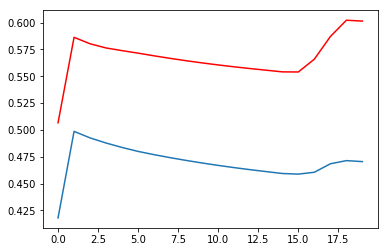

duration: 283.768110991


In [32]:
#input_size =1
encoder = seq2seq(
            input_data_encoded,
            output_data,
            sos_encoded,
            weight_matrix,
            train_ = 1,
            input_size = input_size,
            output_size = input_size,
            hidden_size = 20,
            n_epochs = 20,
            learning_rate=0.001
        )